In [137]:
import matplotlib.pyplot as plt
import json
import numpy as np
import math
from config import PARAS

# Training Stage
## Pure clustering model

In [2]:
with open(PARAS.LOG_PATH + 'dc_model.json', 'r') as f:
    dc_log = json.load(f)

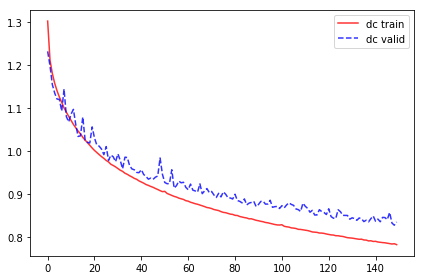

In [3]:
plt.figure()
plt.plot(dc_log['train_loss'], '-', color=(1,0,0,0.8), label='dc train')
plt.plot(dc_log['valid_loss'], '--', color=(0,0,1,0.8), label='dc valid')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## cluster-mask model

In [4]:
with open(PARAS.LOG_PATH + 'hd_model.json') as f:
    hd_log = json.load(f)

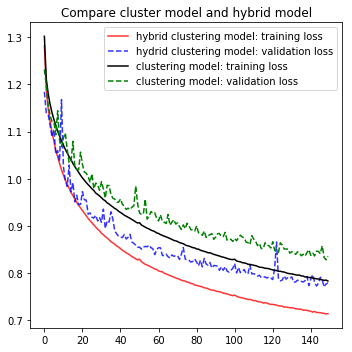

In [122]:
plt.figure(figsize=(5,5))
plt.plot(hd_log['train_loss_dc'], '-', color=(1,0,0,0.8), label='hybrid clustering model: training loss')
plt.plot(hd_log['valid_loss_dc'], '--', color=(0,0,1,0.8), label='hydrid clustering model: validation loss')
plt.plot(dc_log['train_loss'], '-', color='black', label='clustering model: training loss')
plt.plot(dc_log['valid_loss'], '--', color='g', label='clustering model: validation loss')
plt.legend(loc="best")
plt.title("Compare cluster model and hybrid model")
plt.tight_layout()
plt.savefig('dc_loss.png')
plt.show()

## Pure U_net model

In [6]:
with open(PARAS.LOG_PATH + 'unet_model.json') as f:
    unet_log = json.load(f)

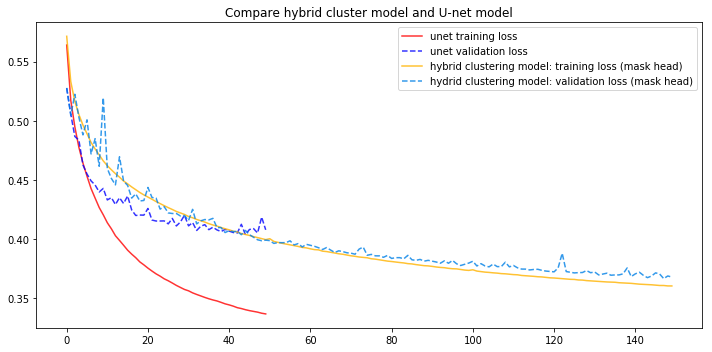

In [123]:
plt.figure(figsize = (10, 5))
plt.plot(unet_log['train_loss'], '-', color=(1,0,0,0.8), label='unet training loss')
plt.plot(unet_log['valid_loss'], '--', color=(0,0,1,0.8), label='unet validation loss')
plt.plot(hd_log['train_loss_mask'], '-', color=(1,0.7,0,0.8), label='hybrid clustering model: training loss (mask head)')
plt.plot(hd_log['valid_loss_mask'], '--', color=(0,0.5,0.9,0.8), label='hydrid clustering model: validation loss (mask head)')
plt.legend(loc="best")
plt.title("Compare hybrid cluster model and U-net model")
plt.tight_layout()
plt.savefig('u_net_loss.png')
plt.show()

## Clustering U_net model

In [8]:
with open(PARAS.LOG_PATH + 'uhnet_model.json') as f:
    uhnet_log = json.load(f)

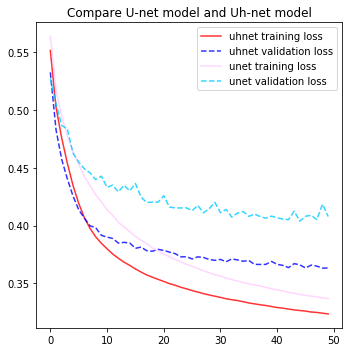

In [125]:
plt.figure(figsize=(5, 5))
plt.plot(uhnet_log['train_loss'], '-', color=(1,0,0,0.8), label='uhnet training loss')
plt.plot(uhnet_log['valid_loss'], '--', color=(0,0,1,0.8), label='uhnet validation loss')
plt.plot(unet_log['train_loss'], '-', color=(1,0.8,1,0.8), label='unet training loss')
plt.plot(unet_log['valid_loss'], '--', color=(0,0.8,1,0.8), label='unet validation loss')
plt.legend(loc="best")
plt.title("Compare U-net model and Uh-net model")
plt.tight_layout()
plt.savefig('uhnet_loss.png')
plt.show()

# Test Model

## Get file names

In [10]:
import os
MIX_PATH = '../DSD100/Mixtures'
SRC_PATH = '../DSD100/Sources'
test_file_paths = dict()

for (dirpath, dirnames, filenames) in os.walk(MIX_PATH):
    if not dirnames:
        if 'Test' in dirpath:
            file_name = dirpath.split('Test/')[-1].split('-')[0].strip()
            test_file_paths[file_name] = dict()
            test_file_paths[file_name]['mix'] = dirpath + '/' + filenames[0]

for (dirpath, dirnames, filenames) in os.walk(SRC_PATH):
    if not dirnames:
        if 'Test' in dirpath:
            file_name = dirpath.split('Test/')[-1].split('-')[0].strip()
            for trackname in filenames:
                track = trackname.split('.wav')[0]
                test_file_paths[file_name][track] = dirpath + '/' + trackname

In [11]:
test_file_paths['001']

{'mix': '../DSD100/Mixtures/Test/001 - ANiMAL - Clinic A/mixture.wav',
 'drums': '../DSD100/Sources/Test/001 - ANiMAL - Clinic A/drums.wav',
 'vocals': '../DSD100/Sources/Test/001 - ANiMAL - Clinic A/vocals.wav',
 'other': '../DSD100/Sources/Test/001 - ANiMAL - Clinic A/other.wav',
 'bass': '../DSD100/Sources/Test/001 - ANiMAL - Clinic A/bass.wav'}

## Get test set

In [15]:
from data_loader import torch_dataset_loader
from music_decoder import VocalExtractor
from hybrid_model import H_model
from cluster_model import D_model
from evaluation import calculate_score, calculate_double_score
test_loader = torch_dataset_loader(PARAS.DATASET_PATH + 'test.h5', PARAS.BATCH_SIZE, False, PARAS.kwargs)

In [16]:
ve_hd = VocalExtractor(H_model, 'HD_MODEL.pt', 'cluster')
ve_cd = VocalExtractor(D_model, 'DC_MODEL.pt', 'cluster')

### Binary evaluation for cluster model

In [24]:
hd_accuracy = 0.
cd_accuracy = 0.
count = 0
for index, data_item in enumerate(test_loader):
    mix_chunks = data_item.get('mix')
    binary_masks = data_item.get('binary_mask')
    for i, chunk in enumerate(mix_chunks):
        mask_hd = ve_hd.get_cluster_out(chunk)
        mask_dc1, mask_dc2 = ve_cd.get_simple_cluster_out(chunk)
        
        score_hd = calculate_score(mask_hd, binary_masks[i].numpy())
        score_cd = calculate_double_score(binary_masks[i].numpy(),mask_dc1, mask_dc2)
        hd_accuracy += score_hd
        cd_accuracy += score_cd
        count += 1
        if count == 500:
            break
hd_accuracy /= count
cd_accuracy /= count
print(hd_accuracy, cd_accuracy)

0.7944382522636926 0.7478150708094081


### scale evaluation for both model

In [44]:
import mir_eval
from mel_dealer import mel_converter
from IPython.display import Audio

In [28]:
from unet_model import UNet, UNetEnhanced

U_model = UNet()
UH_model = UNetEnhanced('HD_model.pt')

In [30]:
ve_unet = VocalExtractor(U_model, 'UNET_MODEL.pt', 'mask')
ve_uhnet = VocalExtractor(UH_model, 'UHNET_MODEL.pt', 'mask')

In [176]:
def music_score_function(vocal, vocal_from_audio):
    """
    (sdr, sir, sar, perm)
    """
    sub_vocal = librosa.util.normalize(vocal)
    
    sub_vocal_from_audio = librosa.util.normalize(vocal_from_audio)
    return mir_eval.separation.bss_eval_sources(sub_vocal, 
                                                sub_vocal_from_audio,
                                               compute_permutation=False)

In [150]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [184]:
count = 0
unetS, unetHS, hdS, mixS = 0, 0, 0, 0
for index, data_item in enumerate(test_loader):
    mix_chunks = data_item.get('mix')
    vocal_chunks = data_item.get('vocal')
    for i, chunk in enumerate(mix_chunks):
        mix = mel_converter.melspec_to_audio(mix_chunks[i].numpy(), audio_out=False)
        vocal = mel_converter.melspec_to_audio(vocal_chunks[i].numpy(), audio_out=False)
        vocal_hd = ve_hd.gain_chunk_result(chunk.numpy())
        vocal_unet = ve_unet.gain_chunk_result(chunk.numpy())
        vocal_uhnet = ve_uhnet.gain_chunk_result(chunk.numpy())
        
        unetS += music_score_function(vocal, vocal_unet)[0][0]
        unetHS += music_score_function(vocal, vocal_uhnet)[0][0]
        hdS += music_score_function(vocal, vocal_hd)[0][0]
        mixS += music_score_function(vocal, mix)[0][0]
        count += 1
    if count > 100:
        break
print(unetS/count, unetHS/count, hdS/count, mixS/count )
        

-7.505905506271413 -7.278469851783084 -7.899927659964983 -11.48622430629697


In [156]:
score_unet = 0
score_uhnet = 0
count = 0

for index, data_item in enumerate(test_loader):
    mix_chunks = data_item.get('mix')
    scale_chunks = data_item.get('scale_mask')
    for i, chunk in enumerate(mix_chunks):
        scale_mask = scale_chunks[i].numpy()
        mask_unet = ve_unet.get_unet_out(chunk)
        mask_uhnet = ve_uhnet.get_unet_out(chunk)
        score_unet += psnr(scale_mask, mask_unet)
        score_uhnet += psnr(scale_mask, mask_uhnet)
        count += 1
    if count > 500:
        break
print(score_unet / count, score_uhnet / count)

16.24334415396326 17.122128743123174


In [155]:
print(score_unet / count, score_uhnet / count)

0.0 0.0


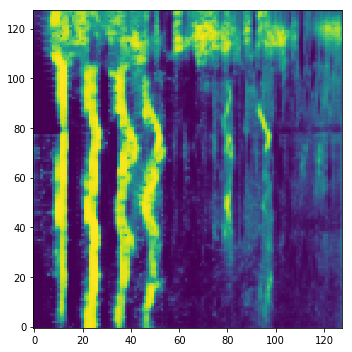

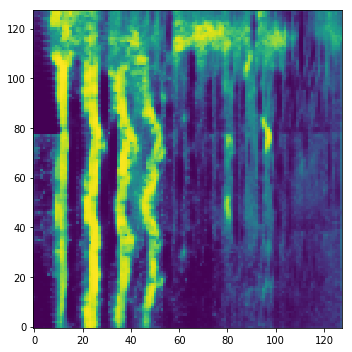

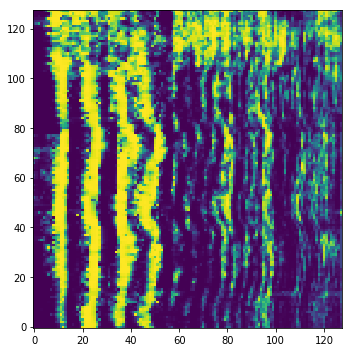

In [144]:
plt.figure(figsize=(5, 5))
plt.imshow(mask_uhnet, aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(mask_unet, aspect='auto', origin='lower')
plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5))
plt.imshow(scale_mask, aspect='auto', origin='lower')
plt.tight_layout()
plt.show()

In [190]:
vocal_path = test_file_paths['007'].get('vocals')
mix_path = test_file_paths['007'].get('mix')

In [191]:
vocal_signal, _ = librosa.load(vocal_path, sr=PARAS.SR)
mix_signal, _ = librosa.load(mix_path, sr=PARAS.SR)

In [192]:
audio_hd = ve_hd.vocal_extractor(mix_signal)
audio_unet = ve_unet.vocal_extractor(mix_signal)
audio_uhnet = ve_uhnet.vocal_extractor(mix_signal)

In [200]:
librosa.output.write_wav('../Sample Audio/hdcluster.wav', np.array(audio_hd), PARAS.SR)

In [201]:
librosa.output.write_wav('../Sample Audio/vocal.wav', np.array(vocal_signal), PARAS.SR)

In [202]:
librosa.output.write_wav('../Sample Audio/mix.wav', np.array(mix_signal), PARAS.SR)

In [203]:
librosa.output.write_wav('../Sample Audio/unet.wav', np.array(audio_unet), PARAS.SR)

In [204]:
librosa.output.write_wav('../Sample Audio/uhnet.wav', np.array(audio_uhnet), PARAS.SR)

In [117]:
print(music_score_function(vocal_signal[: len(audio_uhnet)], np.array(audio_uhnet)))
print(music_score_function(vocal_signal[: len(audio_unet)], np.array(audio_unet)))
print(music_score_function(vocal_signal[: len(audio_hd)], np.array(audio_hd)))

(array([-35.90113363]), array([inf]), array([-35.90113363]), array([0]))
(array([-35.98245155]), array([inf]), array([-35.98245155]), array([0]))
(array([-35.83009419]), array([inf]), array([-35.83009419]), array([0]))


In [118]:
print(music_score_function(vocal_signal, mix_signal))

(array([-7.19161115]), array([inf]), array([-7.19161115]), array([0]))
